# Arbitrage - implied volatility solver and parametrization
This project provides a comprehensive exploration of tools developed within Arbitrage for implied volatility, from solving the black scholes equation using the Let's Be Rational framework to parametrizing the volatility surface with the SVI model. These tools are essential for understanding market dynamics, pricing derivatives, and managing risk in financial markets.


## Let's be rational  
The **Let's Be Rational** framework has been implemented here as a robust and efficient method for solving the implied volatility of European vanilla options. This framework is particularly well-suited for calculating implied volatility from option prices, as it combines numerical stability with high computational efficiency.

### Overview of the Model:
The **Let's Be Rational** algorithm, developed by Peter Jäckel, is designed to compute implied volatility for European vanilla options by inverting the Black-Scholes pricing formula. Unlike traditional iterative methods (e.g., Newton-Raphson), this framework leverages analytical approximations and rational function interpolation to achieve:
- **High accuracy**: The method provides results with machine precision.
- **Speed**: It is optimized for performance, making it suitable for large-scale computations.
- **Robustness**: It avoids common pitfalls like divergence or instability in edge cases (e.g., deep in-the-money or out-of-the-money options).

This implementation ensures that the implied volatility solver is both reliable and efficient, making it a valuable tool for financial modeling and arbitrage analysis.

### Normalized black price 

To begin, we first showcase the Normalized Black Price as a function of volatility in the following graph. This visualization helps illustrate the relationship between the normalized price and volatility, which is a key component of the implied volatility solver.

Normalized Black Price Equation:
The normalized Black price is given by the following equation:

$$b(\theta,x,\sigma) = B(\theta, F, K, \tilde{\sigma}, T) / \sqrt{FK} =  \theta \{e^{x/2} \Phi(\theta d_+) - e^{-x/2} \Phi(\theta d_-)\}$$

This equation is central to the Let's Be Rational framework, as it simplifies the inversion problem by reducing the function to 2 single arguments. Here's a representation of the normalized black price with $\mid x \mid = 4$ (LBR paper's example) with respect to vollatility: 

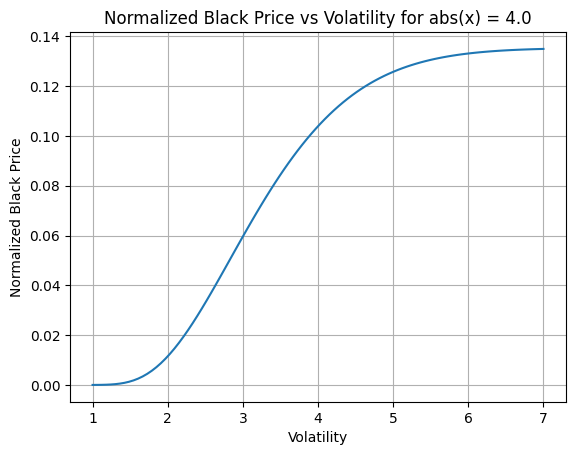

In [2]:
from arbitrage.frameworks.letsberational import LetsBeRational, get_normalized_black_price
import numpy as np
import matplotlib.pyplot as plt

x = - 4.0
abs_x = abs(x)
sigma = np.linspace(1, 7, 100)
price = [get_normalized_black_price(x, s, True) for s in sigma]
plt.plot(sigma, price)
plt.title('Normalized Black Price vs Volatility for abs(x) = ' + str(abs_x))
plt.xlabel('Volatility')
plt.ylabel('Normalized Black Price')
plt.grid()
plt.show()

The real breakthrough of the Let's Be Rational framework lies in its ability to compute an initial guess for the implied volatility that is extremely close to the exact solution, even before applying iterative methods. This is achieved by leveraging asymptotic behaviors and rational cubic interpolation.

Key Innovations:
Asymptotic Behaviors:

The framework analyzes the behavior of the implied volatility in extreme cases, such as deep in-the-money or out-of-the-money options, to derive highly accurate approximations.
These approximations provide a solid foundation for the initial guess, reducing the need for extensive iterations.
Rational Cubic Interpolation:

By using rational cubic functions, the algorithm interpolates between known points with high precision.
This interpolation ensures that the initial guess is not only accurate but also computationally efficient, minimizing the number of iterations required for convergence.
This combination of techniques allows the Let's Be Rational framework to achieve near-exact results with minimal computational effort, making it a highly efficient and reliable tool for solving implied volatility.

Here's some example for different $\mid x \mid$ oof the initial guess function versus its exact value. We can see that the initial guess is very precise already without any type of iterations yet. Even for very low/high values of sigma, the initial guess algorithm is very smart and robust. This leverage the use of any type of optimization method with very solid intial guess, which will limit the number of iteration and increase drastically the chances of convergence. 

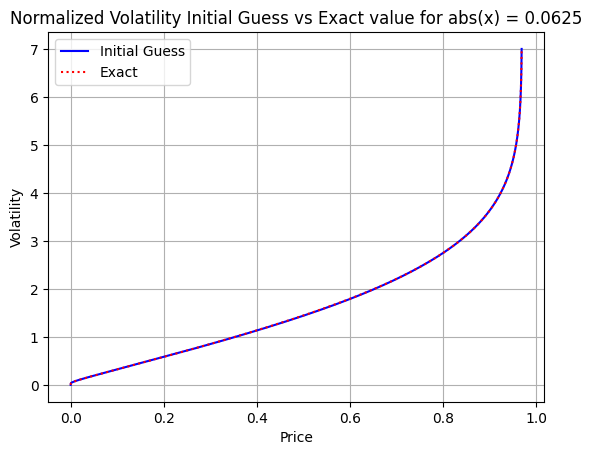

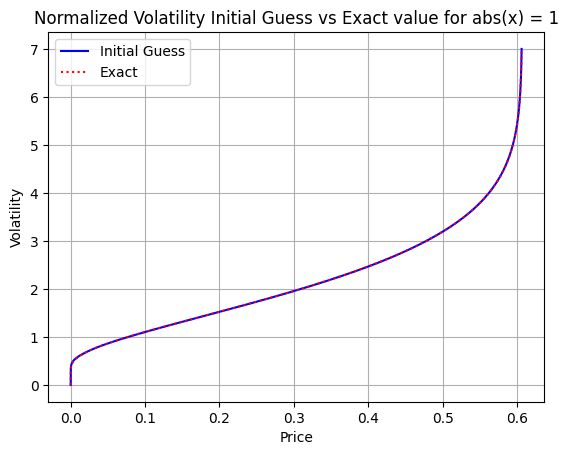

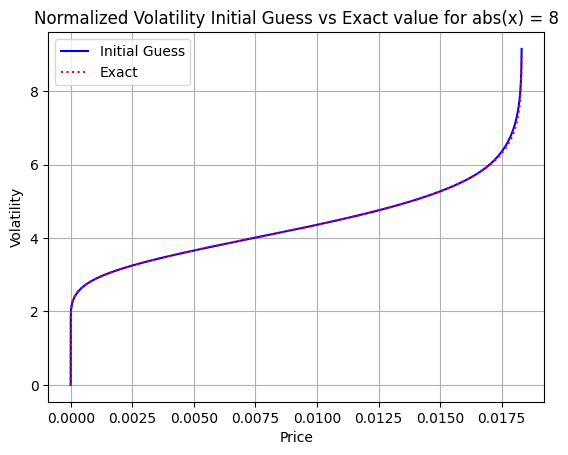

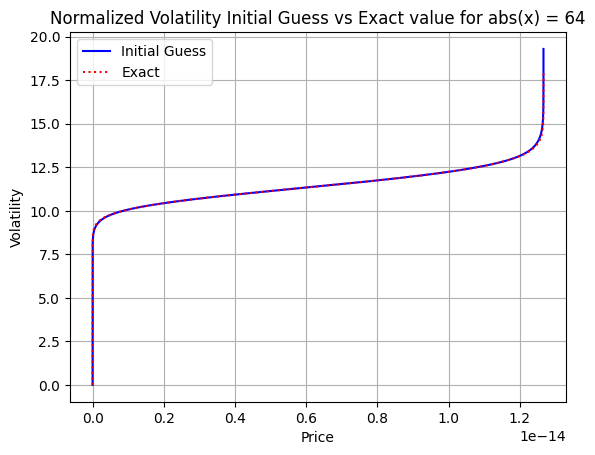

In [5]:
from arbitrage.frameworks.letsberational import LetsBeRational, get_normalized_black_price
import numpy as np
import matplotlib.pyplot as plt

def test_function_initial_guess(x:float =4.0, sigma_max:float = 7.0):
    """
    Test the function get_normalized_volatility_initial_guess with a specific value of abs_x.
    """
    x = - x
    abs_x = abs(x)
    sigma = np.linspace(0.001, sigma_max, 1000)
    price = [get_normalized_black_price(x, s, True) for s in sigma]

    #plt.plot(sigma, price)
    #plt.title('Normalized Black Price vs Volatility for abs(x) = ' + str(abs_x))
    #plt.xlabel('Volatility')
    #plt.ylabel('Normalized Black Price')
    #plt.grid()
    #plt.show()

    iv = [LetsBeRational(price, x, True).get_initial_guess_normalized_volatility() for price in price]
    plt.plot(price, iv, color='blue', label='Initial Guess')  # Blue for 'Initial Guess'
    plt.plot(price, sigma, color='red', linestyle='dotted', label='Exact')  # Red dotted for 'Exact'
    plt.legend()
    plt.title('Normalized Volatility Initial Guess vs Exact value for abs(x) = ' + str(abs_x))
    plt.xlabel('Price')
    plt.ylabel('Volatility')
    plt.grid()
    plt.show()


test_function_initial_guess(1/16)
test_function_initial_guess(1)
test_function_initial_guess(8, 9.0)
test_function_initial_guess(64, 18.0)

## Stochastic volatility inspired - Arbitrage free parametrization of smile and surface

A volatility surface is free of static arbitrage if and only if the following conditions are satisfied:
- it is free of calendar spread arbitrage: A volatility surface $w$ is free of calendar spread if $\partial_t w(k,t) \geq 0$
- each time slice is free of butterfly arbitrage: A slice is free of butterfly arbitrage if and only if $g(k) \geq 0$ for all $k \in \mathbb{R}$ and if $\lim_{k \rightarrow 0} d_+(k) = -\inf$ (see Breeden and Litzenberger, 1978 for the first condition). The second condition comes from the fact that a call price must converges to 0 as k converges to infinity. 